In [27]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import shap

# Suppress warnings
warnings.filterwarnings("ignore")

In [42]:
# Read csv
df = pd.read_csv('df_user_aggregated.csv')

# Modelling

In [43]:
df.head()

,new_id,SUCCESS_LEVEL_last,GENDER_first,ADMIT_TERM_CODE_first,APPL_STATUS_IN_CA_NAME_first,CURRENT_STAY_STATUS_last,PRIMARY_PROGRAM_CODE_first,SessionId_count,Timestamp_min,Timestamp_max,unique_active_days,log_deviation_from_program,rolling_7d_avg_logs,daily_log_variance,weekly_log_variance,longest_consecutive_active_days,rolling_avg_trend_slope,session_span_days,AGE_GROUP_ordinal,ACADEMIC_PERFORMANCE_ordinal
0,0000cf80a3f3206a,Successful,F,2022-09-01,Study Permit (student visa),Graduated - On Time,1207.0,524,2022-09-01,2022-12-10,93,63.506024,5.558474,11.017064,171.495238,41,0.028198,100.0,5,2
1,00024c40cef486cc,Unsuccessful,M,2022-09-01,Canadian Citizen,Left College - Enrolled 2 Terms,3703.0,157,2022-09-06,2022-12-10,59,-182.703704,2.735997,4.676213,33.873626,7,-0.006229,95.0,0,0
2,0002d2ebd89ea8cd,Successful,M,2022-09-01,Study Permit (student visa),Graduated - On Time,3776.0,437,2022-09-06,2022-12-10,92,-142.180328,4.655797,5.793956,56.335165,33,0.024245,95.0,4,2
3,000698ff5c581e09,Successful,F,2022-09-01,Study Permit (student visa),Graduated - On Time,2890.0,302,2022-09-01,2022-12-10,84,-55.629032,3.532313,7.906483,108.980952,35,0.015935,100.0,3,2
4,000915a44be41906,Unsuccessful,F,2022-09-01,Study Permit (student visa),Stepped Out - 2 Terms Away,3109.0,431,2022-09-06,2022-12-10,82,105.938462,5.345064,11.155827,148.027473,21,-0.011169,95.0,2,1


In [83]:
df_model = df.copy()

# Set index to new_id
df_model.set_index('new_id', inplace=True)

# Convert boolean columns to int
df_model['SUCCESS_STATUS'] = (df_model['SUCCESS_LEVEL_last'] == 'Successful').astype(int)
df_model.drop('SUCCESS_LEVEL_last',axis=1,inplace=True)

# Convert categorical columns to category type
categorical_cols = df_model.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_model[col] = df_model[col].astype('category')

# Convert primary program code to category
df_model['PRIMARY_PROGRAM_CODE_first'] = df_model['PRIMARY_PROGRAM_CODE_first'].astype('category')


# Define features and target
features_to_exclude = [
    'ADMIT_TERM_CODE_first',
    'session_span_days',
    'AGE_GROUP_ordinal',
    'SUCCESS_STATUS',         # Target variable
    'Timestamp_min',          # Drop time-related columns
    'Timestamp_max',
    'CURRENT_STAY_STATUS_last',  # Drop columns with categorical data that shouldn't be in features
    'APPL_STATUS_IN_CA_NAME_first',
    'ACADEMIC_PERFORMANCE_ordinal',
    'GENDER_first' #
    # ,'PRIMARY_PROGRAM_CODE_first'           
]

# Feature matrix (X) and target vector (y)
X = df_model.drop(columns=features_to_exclude)
y = df_model['SUCCESS_STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [114]:

# --- 2. Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
}

# --- 3. Set up scorer ---
f1_scorer = make_scorer(f1_score, average='weighted')

# --- 4. Stratified K-Fold setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5. Define base XGBoost model ---
base_model = XGBClassifier(
    enable_categorical=True,
    eval_metric='logloss',
    booster='gbtree',
    random_state=42,
    n_jobs=-1
)

# --- 6. Grid search with cross-validation ---
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    error_score='raise'
)

# --- 7. Train the model ---
grid_search.fit(X_train, y_train)

# --- 8. Make predictions ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- 9. Report best results ---
print("\n Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n Best Weighted F1 Score (CV): {grid_search.best_score_:.4f}")

# --- 10. Evaluate on test set ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

# --- 11. Predict probabilities for later use ---
y_pred_proba = best_model.predict_proba(X_test)



 Best Hyperparameters:
   - colsample_bytree: 0.8
   - gamma: 0
   - learning_rate: 0.1
   - max_depth: 5
   - n_estimators: 150
   - subsample: 0.8

 Best Weighted F1 Score (CV): 0.7755

Classification Report:
              precision    recall  f1-score   support

           0     0.7740    0.7961    0.7849      4860
           1     0.7857    0.7628    0.7741      4764

    accuracy                         0.7796      9624
   macro avg     0.7798    0.7794    0.7795      9624
weighted avg     0.7798    0.7796    0.7795      9624


Confusion Matrix:
      0     1
0  3869   991
1  1130  3634


In [115]:
X_train.head()

,PRIMARY_PROGRAM_CODE_first,SessionId_count,unique_active_days,log_deviation_from_program,rolling_7d_avg_logs,daily_log_variance,weekly_log_variance,longest_consecutive_active_days,rolling_avg_trend_slope
new_id,,,,,,,,,
01fd7f03efedb66b,5850.0,646,93,42.196000,6.723400,19.638382,406.923810,45,0.010003
03a04d3f0913f1c1,1811.0,399,86,-44.832487,4.695044,9.480301,79.192308,30,-0.018155
05b61af0c5be08b0,6616.0,262,80,-1.828326,3.324494,3.037342,36.681319,11,-0.017154
3644ac37f667134e,1824.0,298,66,-162.864553,4.463456,12.899767,171.910256,13,-0.020069
482a2b63010b55dd,1823.0,487,72,-42.884848,6.579134,20.267410,207.218182,68,0.029346


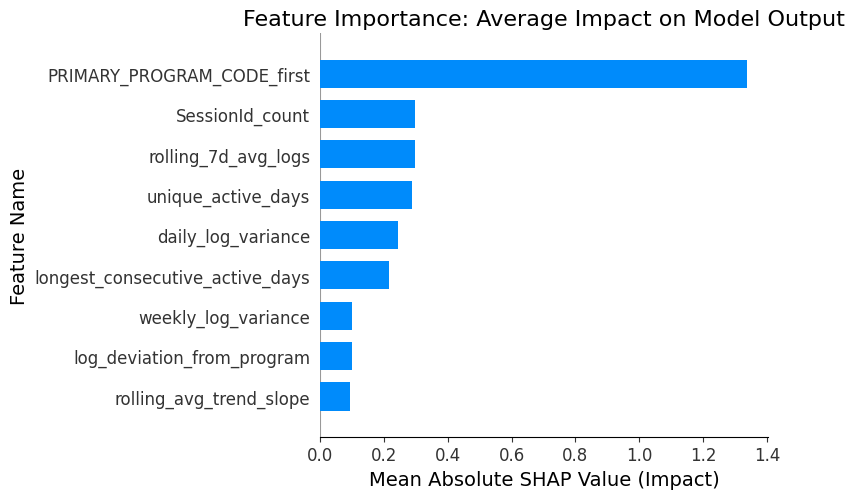

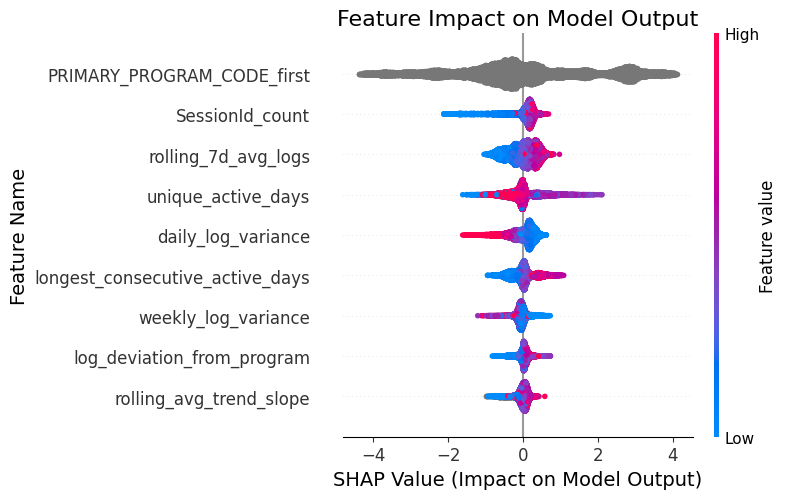

In [116]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# --- Summary Plot (Bar) ---
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type="bar", 
    max_display=10, 
    show=False  # Prevent auto-display to customize
)
plt.title("Feature Importance: Average Impact on Model Output", fontsize=16)
plt.xlabel("Mean Absolute SHAP Value (Impact)", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- Summary Plot (Scatter/Violin) ---
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
shap.summary_plot(
    shap_values, 
    X_train, 
    max_display=10, 
    show=False  # Prevent auto-display to customize
)
plt.title("Feature Impact on Model Output", fontsize=16)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

